# Advanced Lane Finding Project:

## Import Dependencies

In [35]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline

## Load Images and Find Corners

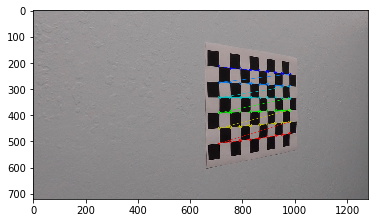

In [36]:
def load_calibration_images():
    paths = glob.glob('camera_cal/*.jpg')
    return np.array([cv2.imread(path) for path in paths])

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

def to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def find_corners(image, name = None):
    ret, corners = cv2.findChessboardCorners(to_gray(image), (9, 6), None)
    if not ret:
        print('could not find corners in image: {}'.format(name))
        return 
    
    return corners
            
def draw(image, corners):
    if corners is None:
        print('no corners to draw')
    painted = cv2.drawChessboardCorners(image, (9, 6), corners, True)
    plt.imshow(painted)

            
images = load_calibration_images()
image_num = 19

image = images[image_num]
corners = find_corners(image, image_num)
draw(image, corners)

# Get Points and Define Calibrate 

In [37]:


def get_points(images):
    obj_points = []
    img_points = []
    
    for i, image in enumerate(images):
        corners = find_corners(image, i)
        if corners is not None:
            obj_points.append(objp)
            img_points.append(corners)
    return obj_points, img_points
    

def undistort_image(image, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, to_gray(image).shape[::-1], None, None)
    return cv2.undistort(image, mtx, dist, None, mtx)


obj_points, img_points = get_points(images)

could not find corners in image: 0
could not find corners in image: 1
could not find corners in image: 6
could not find corners in image: 19


# Calibrate and Visualize

Text(0.5,1,'Undistorted Image')

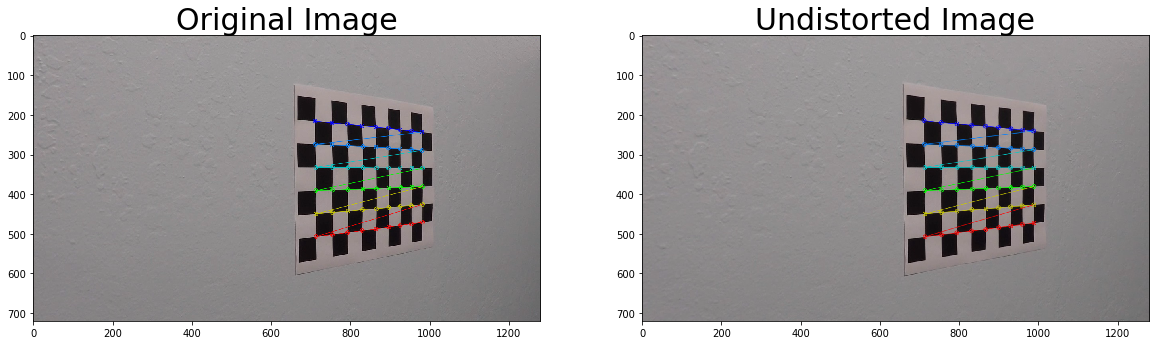

In [38]:
calibrated = undistort_image(image, obj_points, img_points)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(calibrated)
ax2.set_title('Undistorted Image', fontsize=30)

# Load Test Images

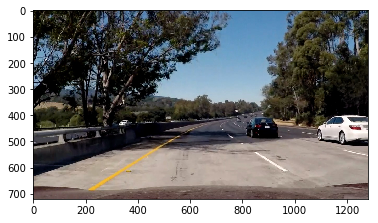

In [39]:
def load_road_images():
    road_images = []
    paths = glob.glob('test_images/*.jpg')
    for path in paths: 
        road_images.append(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))
        
    return road_images

road_images = load_road_images()    
road_image_num = 1
road_image = road_images[road_image_num]
plt.imshow(road_image)

# Undistorted Image

Text(0.5,1,'Undistorted Image')

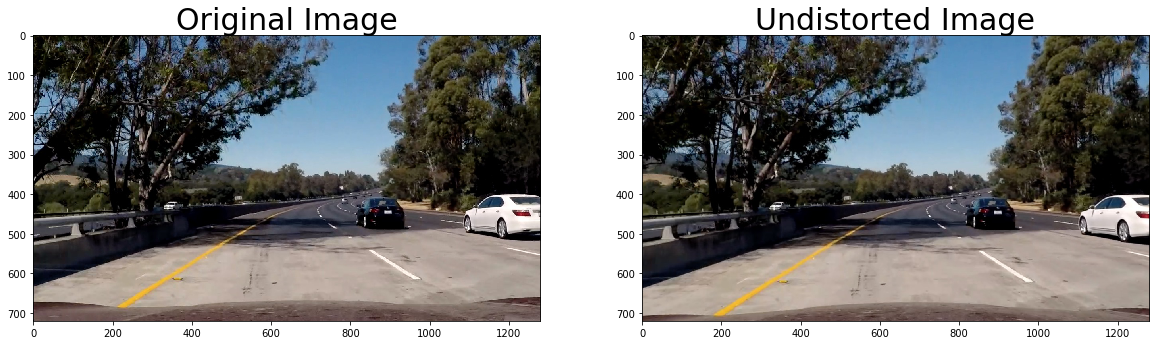

In [40]:
undistorted_images = []

for i, image in enumerate(road_images):
    image = undistort_image(image, obj_points, img_points)
    plt.imsave('undistorted/undistorted-{}.jpg'.format(i), image)
    undistorted_images.append(image)
    
undistorted_image = undistorted_images[road_image_num]   

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(road_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=30)

# Gradient Threshold Testing

## Gray x and y threshold

Text(0.5,1,'y image')

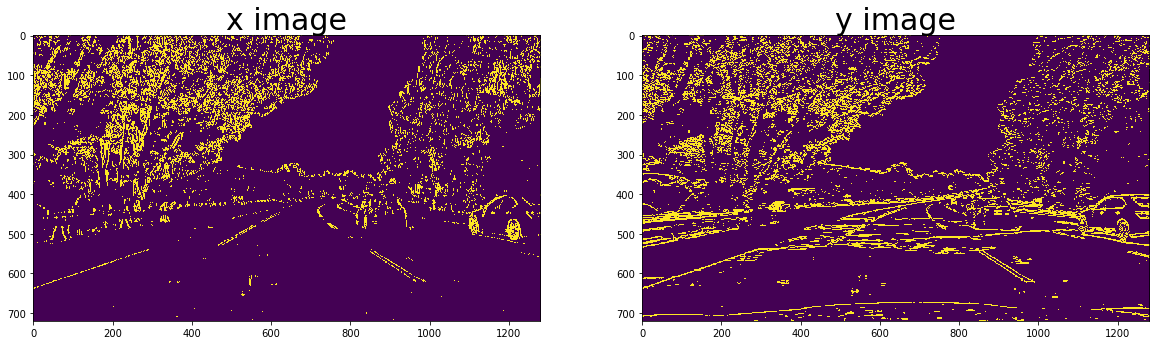

In [41]:
def abs_sobel_threshold(img_channel, orient='x', sobel_kernel=3, thresh=(0, 255)):
    sobel_x_param = 1 if orient == 'x' else 0
    sobel_y_param = 1 if orient == 'y' else 0
    sobel = cv2.Sobel(img_channel, cv2.CV_64F, sobel_x_param, sobel_y_param, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    thresh_min, thresh_max = thresh
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

x_gray_binary = abs_sobel_threshold(to_gray(undistorted_image), orient='x', thresh=(20, 255), sobel_kernel=3)
y_gray_binary = abs_sobel_threshold(to_gray(undistorted_image), orient='y', thresh=(20, 255), sobel_kernel=3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(x_gray_binary)
ax1.set_title('x image', fontsize=30)
ax2.imshow(y_gray_binary)
ax2.set_title('y image', fontsize=30)

## Magnatude Threshold

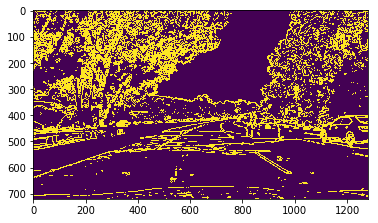

In [42]:
def mag_threshold(img_channel, sobel_kernel=3, mag_thresh=(0, 255)):
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    thresh_min, thresh_max = mag_thresh
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

mag_gray_thresh = mag_threshold(to_gray(undistorted_image), mag_thresh=(20, 255), sobel_kernel=5)
plt.imshow(mag_gray_thresh)

# Direction Threshold

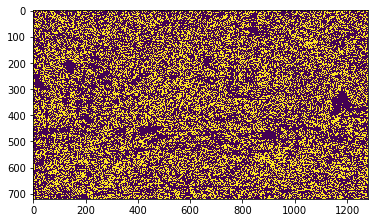

In [43]:
def dir_threshold(img_channel, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    scaled_sobel = direction
    # 5) Create a binary mask where direction thresholds are met
    thresh_min, thresh_max = thresh
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

dir_gray_threshold = dir_threshold(to_gray(undistorted_image), sobel_kernel=3, thresh=(0.7, 1.3))
plt.imshow(dir_gray_threshold)

# Combine Thresholds

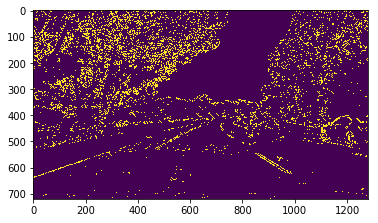

In [44]:
combined_gray = np.zeros_like(dir_gray_threshold)
combined_gray[((x_gray_binary == 1) & (y_gray_binary == 1)) | ((mag_gray_thresh == 1) & (dir_gray_threshold == 1))] = 1
plt.imshow(combined_gray)

# Color Thresholding

In [45]:
def channel_threshhold(image_channel, thresh=(150, 255)):
    min_thresh, max_thresh = thresh
    binary = np.zeros_like(image_channel)
    binary[(image_channel > min_thresh) & (image_channel <= max_thresh)] = 1
    return binary

def to_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

def to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

def to_r(image):
    return image[:, :, 0]

def to_g(image):
    return image[:, :, 1]

def to_b(image):
    return image[:, :, 2]

def to_h(image):
    hls = to_hls(image);
    return hls[:,:,0]

def to_l(image):
    hls = to_hls(image);
    return hls[:,:,1]
    
def to_s(image):
    hls = to_hls(image);
    return hls[:,:,2]

def to_v(image):
    hsv = to_hsv(image)
    return hsv[:, :, 2]

## Gray Thresholding

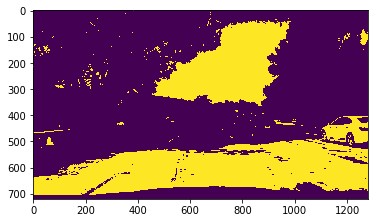

In [46]:
plt.imshow(channel_threshhold(to_gray(undistorted_image),  thresh=(150, 255)))

## Visualize RGB

Text(0.5,1,'Green')

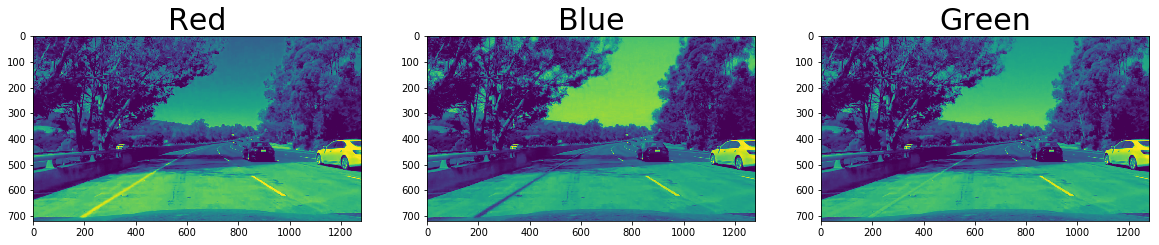

In [47]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(to_r(undistorted_image))
ax1.set_title('Red', fontsize=30)
ax2.imshow(to_b(undistorted_image))
ax2.set_title('Blue', fontsize=30)
ax3.imshow(to_g(undistorted_image))
ax3.set_title('Green', fontsize=30)

## Visualize HLS

Text(0.5,1,'Saturation')

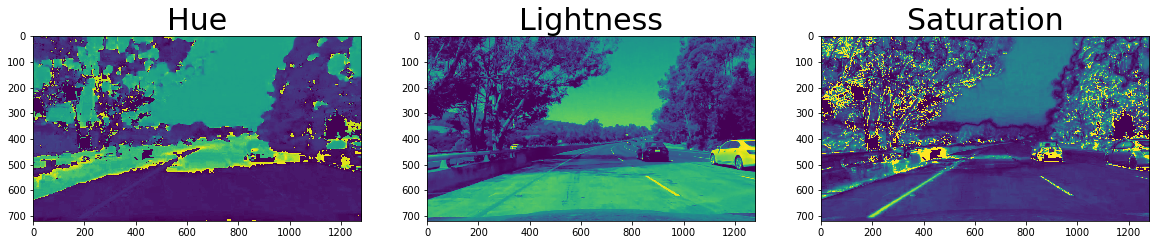

In [48]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(to_h(undistorted_image))
ax1.set_title('Hue', fontsize=30)
ax2.imshow(to_l(undistorted_image))
ax2.set_title('Lightness', fontsize=30)
ax3.imshow(to_s(undistorted_image))
ax3.set_title('Saturation', fontsize=30)

## RGB Channel Threshold

Text(0.5,1,'Green')

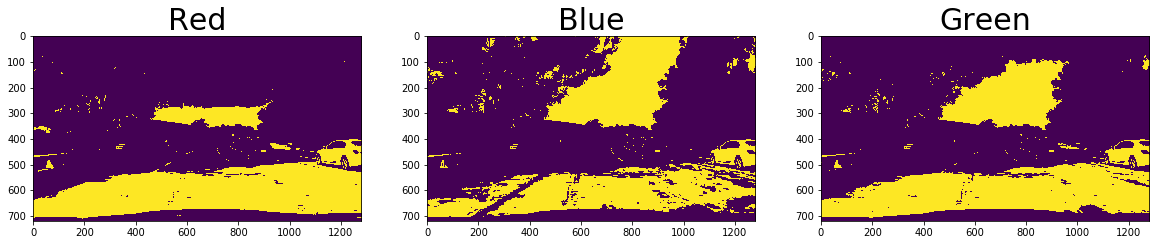

In [49]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(channel_threshhold(to_r(undistorted_image)))
ax1.set_title('Red', fontsize=30)
ax2.imshow(channel_threshhold(to_b(undistorted_image)))
ax2.set_title('Blue', fontsize=30)
ax3.imshow(channel_threshhold(to_g(undistorted_image)))
ax3.set_title('Green', fontsize=30)

## HLS Thresholds

Text(0.5,1,'Saturation')

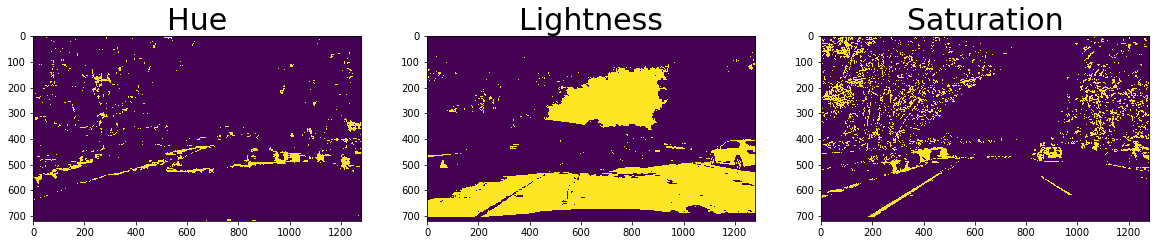

In [50]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(channel_threshhold(to_h(undistorted_image)))
ax1.set_title('Hue', fontsize=30)
ax2.imshow(channel_threshhold(to_l(undistorted_image)))
ax2.set_title('Lightness', fontsize=30)
ax3.imshow(channel_threshhold(to_s(undistorted_image)))
ax3.set_title('Saturation', fontsize=30)

# HSV

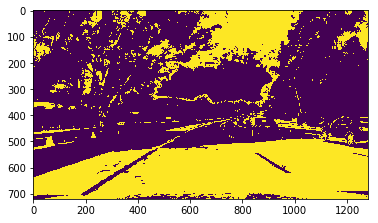

In [51]:
plt.imshow(channel_threshhold(to_v(undistorted_image), thresh=(100, 200)))

## Color and Gradient

Text(0.5,1,'binary image')

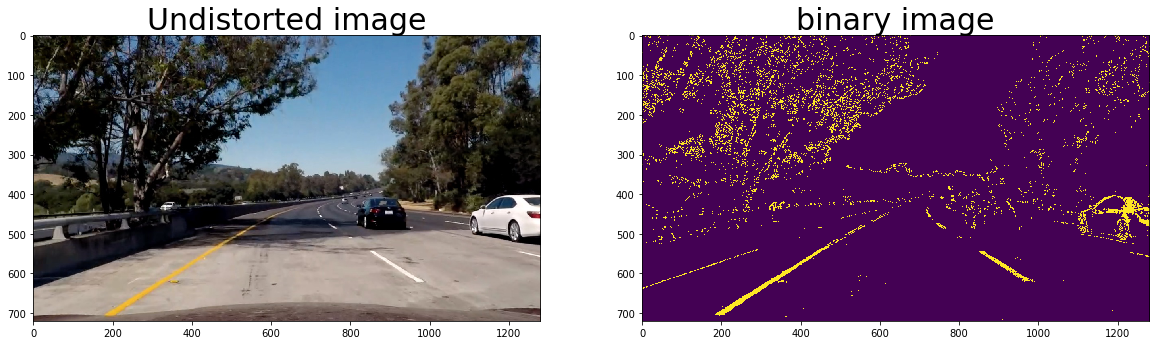

In [52]:
def get_binary_image(image):
    s_color_thresh = channel_threshhold(to_s(image))
    v_color_thresh = channel_threshhold(to_v(image))
    x_grad = abs_sobel_threshold(to_gray(image), orient='x', thresh=(20, 255))
    y_grad = abs_sobel_threshold(to_gray(image), orient='y', thresh=(20, 255))
    
    combined = np.zeros_like(x_gray_binary)
    combined[((x_grad == 1) & (y_grad == 1)) \
               | ((s_color_thresh == 1) & (v_color_thresh == 1))] = 1
    return combined

combined_images = []

for i, image in enumerate(undistorted_images):
    combined = get_binary_image(image)
    plt.imsave('binary/binary-{}.jpg'.format(i), combined)
    combined_images.append(combined)
    
combined_image = combined_images[road_image_num]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistorted_image)
ax1.set_title('Undistorted image', fontsize=30)
ax2.imshow(combined_image)
ax2.set_title('binary image', fontsize=30)

# Perspective Transform

## Find Points

[576, 460]
[704, 460]
[224, 684]
[1056, 684]


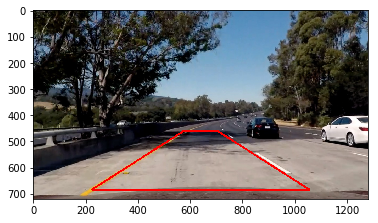

In [53]:
width, height = to_gray(undistorted_image).shape[::-1]
mid_point = width / 2
top_percent = .36
bottom_percent = .05
top = height - height * top_percent
bottom = height - height * bottom_percent
thickness = 5
top_width_percent = .10
bottom_width_percent = .65

top_width = width * top_width_percent / 2
bottom_width = width * bottom_width_percent / 2

bottom_right = [int(mid_point + bottom_width), int(bottom)]
bottom_left = [int(mid_point - bottom_width), int(bottom)]

top_right = [int(mid_point +  top_width), int(top)]
top_left =[int(mid_point - top_width), int(top)]

print(top_left)
print(top_right)
print(bottom_left)
print(bottom_right)

pts = np.array([top_left, top_right, bottom_right, bottom_left])
pts = pts.reshape((-1,1,2))

find_points = []

for i, image in enumerate(undistorted_images):
    lines = cv2.polylines(np.copy(image),[pts],True,(255,0,0), thickness=thickness)
    find_points.append(lines)
    plt.imsave('find_points/find_points-{}.jpg'.format(i), lines)

plt.imshow(find_points[road_image_num])

# Warp Image

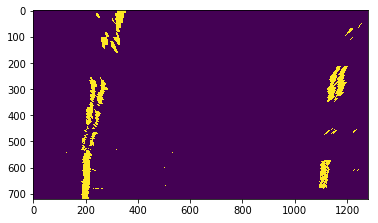

In [54]:
offset = 200
width, height = to_gray(undistorted_image).shape[::-1]

dst_top_right = [width - offset, 0]
dst_bottom_right = [width - offset, height]
dst_bottom_left = [offset, height]
dst_top_left = [offset, 0]

def warp(image, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    
 
src = np.float32([top_right, bottom_right, bottom_left, top_left])
dst = np.float32([dst_top_right, dst_bottom_right, dst_bottom_left, dst_top_left])

warped_images = []
for i, image in enumerate(combined_images):
    warped = warp(image, src, dst)
    warped_images.append(warped)
    plt.imsave('warped/warped-{}.jpg'.format(i), warped)
    
warped = warped_images[road_image_num]

plt.imshow(warped)

## Create threshold image

## Create Histogram Of lowerpart of Image to find lines

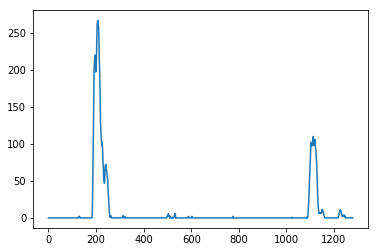

In [55]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

## Find Center Of line

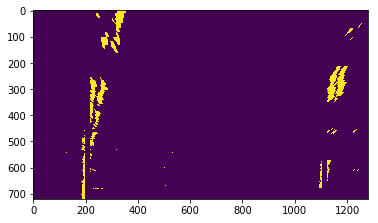

In [56]:
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

left_bottom_line = [leftx_base, 0]
left_top_line = [leftx_base, warped.shape[0]]
right_bottom_line = [rightx_base, 0]
right_top_line = [rightx_base, warped.shape[0]]
warped_center_lines = np.copy(warped)
cv2.line(warped_center_lines, tuple(left_bottom_line), tuple(left_top_line), (0,0,255), thickness=20)
cv2.line(warped_center_lines, tuple(right_bottom_line), tuple(right_top_line), (0,0,255), thickness=20)
plt.imshow(warped_center_lines)

In [57]:
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

out_img = np.dstack((warped, warped, warped))*255

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## Visualize Sliding Window

(720, 0)

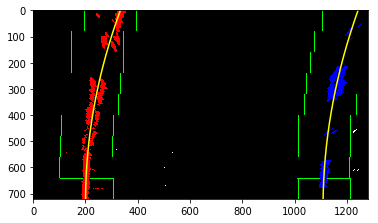

In [58]:
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Using Convolutions

image number: 0
image number: 1
image number: 2
image number: 3
image number: 4
image number: 5
image number: 6
image number: 7
image number: 8
image number: 9


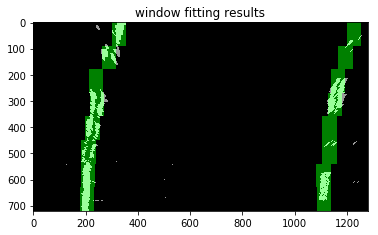

In [59]:
# window settings
window_width = 55 
window_height = 90 # Break image into 9 vertical layers since image height is 720
margin = 50 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
#     # Sum quarter bottom of image to get slice, could use a different ratio
#     l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
#     l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
#     r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
#     r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # find the starting point.
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    l_center = np.argmax(histogram[:midpoint])
    r_center = np.argmax(histogram[midpoint:]) + midpoint
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width / 2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_conv_slice = conv_signal[l_min_index:l_max_index]
        l_max = np.argmax(conv_signal[l_min_index:l_max_index])
        l_center = window_centroids[-1][0] if l_max == 0 and l_conv_slice[0] == 0 else l_max + l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_conv_slice = conv_signal[r_min_index:r_max_index]
        r_max = np.argmax(conv_signal[r_min_index:r_max_index])
        r_center = window_centroids[-1][1] if r_max == 0 and r_conv_slice[0] == 0 else r_max + r_min_index-offset
        
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    return np.array(window_centroids)

        
    

def visualize_sliding_window(warped_ref):
    window_centroids = find_window_centroids(warped_ref, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped_ref)
        r_points = np.zeros_like(warped_ref)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width, window_height, warped_ref, window_centroids[level][0],level)
            r_mask = window_mask(window_width, window_height, warped_ref, window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points + l_points, np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8) # make window pixels green
        warpage= np.dstack((warped_ref, warped_ref, warped_ref)) * 255 # making the original road pixels 3 color channels
        return cv2.addWeighted(warpage, .6, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        return np.array(cv2.merge((warped_ref, warped_ref, warped_ref)), np.uint8)

painted_images = []
    
for i, image in enumerate(warped_images):
    print('image number: {}'.format(i))
    warped_image = visualize_sliding_window(image)
    plt.imsave('painted_lanes/painted_lanes-{}.jpg'.format(i), warped_image)
    painted_images.append(warped_image)
    
painted = painted_images[road_image_num]

# Display the final results
plt.imshow(painted)
plt.title('window fitting results')
plt.show()

In [60]:
yvals = range(0, warped.shape[0])
res_yvals = np.arange(warped.shape[0] - (window_height/2), 0,  -window_height)

def get_curvature(warped_ref):
    window_centroids = find_window_centroids(warped_ref, window_width, window_height, margin)
    left_x = window_centroids[:, :1]
    right_x = window_centroids[:, 1:]

    left_fit = np.polyfit(res_yvals, left_x, 2)
    left_fit_x = np.array(left_fit[0] * yvals * yvals + left_fit[1] * yvals + left_fit[2], np.int32)

    right_fit = np.polyfit(res_yvals, right_x, 2)
    right_fit_x = np.array(right_fit[0] * yvals * yvals + right_fit[1] * yvals +  right_fit[2], np.int32)

    return left_x, right_x, left_fit_x, right_fit_x

## Get Radius

In [61]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(yvals)

def get_radius_of_curve(left_x, right_x):
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(res_yvals*ym_per_pix, left_x*xm_per_pix, 2)
    right_fit_cr = np.polyfit(res_yvals*ym_per_pix, right_x*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

left_x, right_x, left_fit_x, right_fit_x = get_curvature(warped)
print(get_radius_of_curve(left_x, right_x))


(array([ 429.45216934]), array([ 648.70819183]))


## Get Vehicle Offset

In [62]:
def get_vehicle_offset(image, left_x, right_x):
    lane_center = left_x[-1] + right_x[-1] / 2
    return (lane_center - image.shape[1] / 2) * xm_per_pix

left_x, right_x, left_fit_x, right_fit_x = get_curvature(warped)  
print(get_vehicle_offset(warped, left_x, right_x))    

[ 1.58703571]


## Show overlay

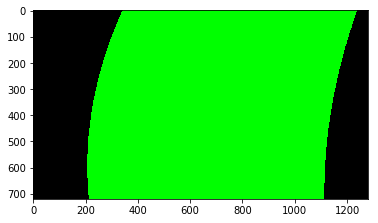

In [63]:
def get_filled_overlay(image, left_x, right_x, left_fit_x, right_fit_x):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit_x, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    return cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
filled_overlay_images = []

for i, image in enumerate(warped_images):
    left_x, right_x, left_fit_x, right_fit_x = get_curvature(image)  
    overlay = get_filled_overlay(image, left_x, right_x, left_fit_x, right_fit_x)
    plt.imsave('poly/poly-{}.jpg'.format(i), overlay)
    filled_overlay_images.append(overlay)
    
filled_overlay_image = filled_overlay_images[road_image_num]
plt.imshow(filled_overlay_image)

## Unwarp and Overlay

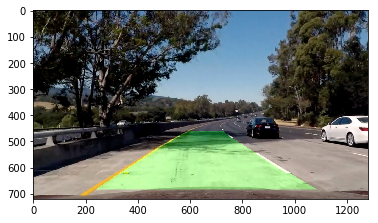

In [64]:
def get_overlayed_image(undistorted, warped_overlay):
    unwarped_overlay = warp(warped_overlay, dst, src)
    return cv2.addWeighted(undistorted, 1, unwarped_overlay, 0.3, 0)

overlayed_images = []
for i, image in enumerate(filled_overlay_images):
    overlayed_image = get_overlayed_image(undistorted_images[i], image)
    overlayed_images.append(overlayed_image)
    plt.imsave('overlayed/overlayed-{}.jpg'.format(i), overlayed_image)
    
overlayed_image = overlayed_images[road_image_num]
plt.imshow(overlayed_image)

## Radius and Vehicle Offset

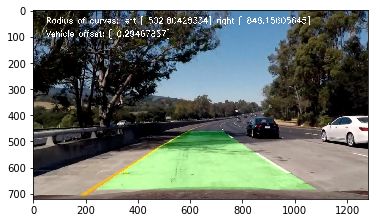

In [65]:
def apply_text_overlay(image, left_x, right_x, left_fit_x, right_fit_x, y_points):
    left_radius, right_radius = get_radius_of_curve(left_x, right_x)
    offset = get_vehicle_offset(image, left_x, right_x)
    
    cv2.putText(image, 'Radius of curves: left {} right {}'.format(left_radius, right_radius), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(image, 'Vehicle offset: {}'.format(offset), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    return image

plt.imshow(apply_text_overlay(np.copy(overlayed_image), left_x, right_x, left_fit_x, right_fit_x, yvals))

## Create Source Image Pipeline.
Must support video and source images. Will take a raw image and perform all of the steps captured above.

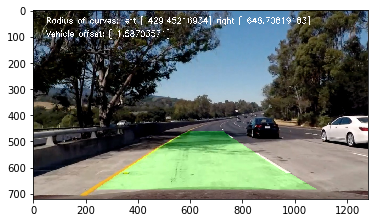

In [66]:
def process_image(image):
    undistorted = undistort_image(image, obj_points, img_points)
    binary = get_binary_image(undistorted)
    # uses src/dst points from testing
    warped_binary = warp(binary, src, dst)
    left_x, right_x, left_fit_x, right_fit_x = get_curvature(warped_binary)
    overlay = get_filled_overlay(warped_binary, left_x, right_x, left_fit_x, right_fit_x)
    overlayed = get_overlayed_image(undistorted, overlay)
    return apply_text_overlay(overlayed, left_x, right_x, left_fit_x, right_fit_x, yvals)

plt.imshow(process_image(road_image))

## Process Video

In [68]:
input_video_path = 'project_video.mp4'
output_video_path = 'overlayed_project_video.mp4'

source_video = VideoFileClip(input_video_path)
processed_video = source_video.fl_image(process_image)
processed_video.write_videofile(output_video_path, audio=False)

[MoviePy] >>>> Building video overlayed_project_video.mp4
[MoviePy] Writing video overlayed_project_video.mp4


100%|█████████▉| 1260/1261 [16:48<00:00,  1.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: overlayed_project_video.mp4 

